# Пропускная способность инференса

In [1]:
# !pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [2]:
from sklearn.datasets import load_digits

ds = load_digits()

X = ds["data"]
y = ds["target"]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

clf = Pipeline([
    # ("scaler", StandardScaler()),
    # ("classifier", LogisticRegression()),
    # ("classifier", RandomForestClassifier(n_estimators=100)),
    ("classifier", CatBoostClassifier(n_estimators=100)),
]).fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 1.5528448	total: 58.8ms	remaining: 5.82s
1:	learn: 1.0792717	total: 72.1ms	remaining: 3.53s
2:	learn: 0.7816384	total: 84ms	remaining: 2.71s
3:	learn: 0.6149772	total: 97.5ms	remaining: 2.34s
4:	learn: 0.5036011	total: 108ms	remaining: 2.06s
5:	learn: 0.4331487	total: 123ms	remaining: 1.92s
6:	learn: 0.3764895	total: 142ms	remaining: 1.89s
7:	learn: 0.3237940	total: 157ms	remaining: 1.81s
8:	learn: 0.2873393	total: 174ms	remaining: 1.75s
9:	learn: 0.2614587	total: 186ms	remaining: 1.68s
10:	learn: 0.2368273	total: 199ms	remaining: 1.61s
11:	learn: 0.2165800	total: 234ms	remaining: 1.72s
12:	learn: 0.1993735	total: 244ms	remaining: 1.63s
13:	learn: 0.1842734	total: 253ms	remaining: 1.55s
14:	learn: 0.1708763	total: 266ms	remaining: 1.51s
15:	learn: 0.1553851	total: 275ms	remaining: 1.45s
16:	learn: 0.1441707	total: 285ms	remaining: 1.39s
17:	learn: 0.1336074	total: 295ms	remaining: 1.34s
18:	learn: 0.1275729	total: 305ms	remaining: 1.3s
19:	learn: 0.11

In [10]:
batch_sizes = [2**i for i in range(10)]

In [11]:
import numpy as np
from timeit import default_timer as timer

n_iterations = 100

elapsed = np.zeros((len(batch_sizes), n_iterations))

for i, bsize in enumerate(batch_sizes):
    for j in range(n_iterations):
        sample_idx = np.random.choice(a=X_test.shape[0], size=bsize)
        batch = X_test[sample_idx]
        start = timer()
        clf.predict(batch)
        end = timer()
        elapsed[i, j] = end - start
        


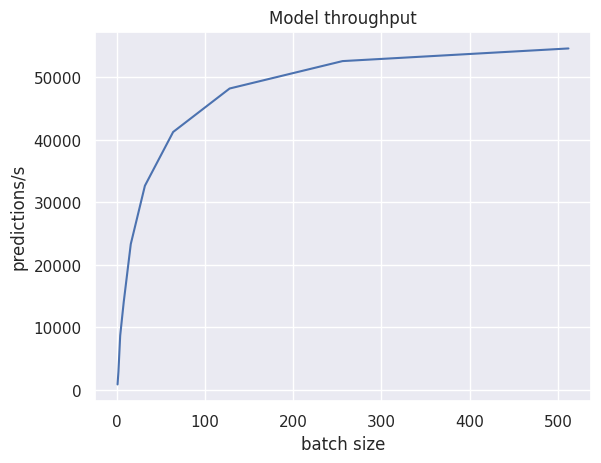

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
elapsed_mean = elapsed.mean(axis=1)

throughput = batch_sizes / elapsed_mean

plt.plot(batch_sizes, throughput)
plt.title("Model throughput")
plt.xlabel("batch size")
plt.ylabel("predictions/s");

## Transformers benchmark

In [13]:
# !pip install transformers==4.26.0 py3nvml -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.0 MB/s eta 0:00:00


In [14]:
from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments

args = PyTorchBenchmarkArguments(models=["bert-base-uncased"], batch_sizes=[8], sequence_lengths=[8, 32, 128, 512])

benchmark = PyTorchBenchmark(args)

/usr/local/lib/python3.10/dist-packages/transformers/benchmark/benchmark_args_utils.py:136: FutureWarning: The class <class 'transformers.benchmark.benchmark_args.PyTorchBenchmarkArguments'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/benchmark/benchmark_utils.py:615: FutureWarning: The class <class 'transformers.benchmark.benchmark.PyTorchBenchmark'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  warnings.warn(


In [15]:
results = benchmark.run()

1 / 1

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
      bert-base-uncased              8               8             0.016     
      bert-base-uncased              8               32            0.011     
      bert-base-uncased              8              128            0.021     
      bert-base-uncased              8              512             0.09     
--------------------------------------------------------------------------------

====================      INFERENCE - MEMORY - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length    Memory in MB 
------------------------------------------